# Kaggle Dog Breed Identification using Pretrained models
> This notebook displays the step to use pretrained imagenet models for transfer learning in Dog Breed Identification playground on Kaggle.
Data can be downloaded from [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data).

1. How data is arranged
3. Custom dataloader for this dataset
4. Some image transformations
5. Finetune Resnet50 with 224x224 image size
6. Finetune Resenet50 with 450x450 image size

---

### Imports

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
# for progress bar
from tqdm import tqdm_notebook, tqdm, trange
# to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

### Paths

In [2]:
data_root = '../../data'
subm_path = '../../submission'
model_path = '../../models'

Training data is available in form of train.zip, test.zip, labels.csv.zip. Labels of the training images are given in labels.csv with image ids.

In [3]:
all_labels_df = pd.read_csv(os.path.join(data_root,'labels.csv'))
all_labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Labels have to supplied in form of indices(integers). Below step is to convert string labels to indices. e.g. boston_bull=0, dingo=1 etc

In [4]:
breeds = all_labels_df.breed.unique()
breed2idx = dict((breed,idx) for idx,breed in enumerate(breeds))
idx2breed = dict((idx,breed) for idx,breed in enumerate(breeds))

In [5]:
all_labels_df['label_idx'] = [breed2idx[b] for b in all_labels_df.breed]
all_labels_df.head()

,id,breed,label_idx
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4


## Custom Dataset

#### There are 2 ways to load data in pytorch if
1. Data is available in keras style folders(i.e. for each target, images are stored in a separate folder)
2. Data is available is other structure e.g. in this this dataset id and breed of dogs are stored in a csv file and all the images are in 1 folder with name of file as the id in the csv. We need to implement our custom dataset to get the image path from csv and load the image. For this we need to inherit torch.utils.data.Dataset class and override \__len\__ and \__getitem\__ methods

In [6]:
??Dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, labels_df, img_path, transform=None):
        self.labels_df = labels_df
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return self.labels_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.img_path, self.labels_df.id[idx]) + '.jpg'
        img = Image.open(image_name)
        label = self.labels_df.label_idx[idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

Load data with CustomDataset

In [8]:
train_ds = CustomDataset(all_labels_df,os.path.join(data_root,'train_original'))
len(train_ds)

10222

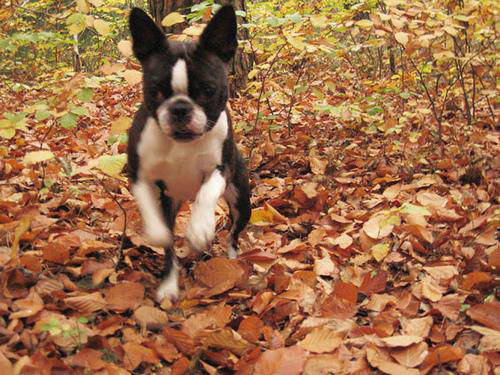

In [9]:
train_ds[0][0]

## Some example transformations

In [10]:
tfms_resize = transforms.Resize(224)
tfms_random_crop = transforms.RandomCrop(224)
tfms_center_crop = transforms.CenterCrop(224)
tfms_random_rotate = transforms.RandomRotation(10)
tfms_hflip = transforms.RandomHorizontalFlip()
tfms_vflip = transforms.RandomVerticalFlip()

all_tfms = [tfms_resize,tfms_random_crop,tfms_center_crop,tfms_random_rotate,tfms_hflip,tfms_vflip]

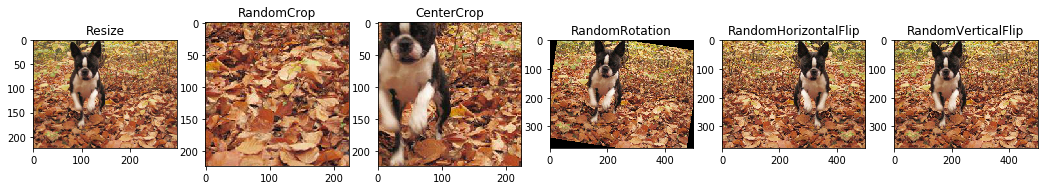

In [11]:
fig, axs = plt.subplots(1,len(all_tfms),figsize=(18,7));
for idx, tfms in enumerate(all_tfms):
    ax = axs[idx].imshow(tfms(train_ds[0][0]));
    ax = axs[idx].set_title(type(tfms).__name__)

---

## Finetune Resnet50 with 224x224 image size

In [12]:
img_size = 224
bs = 64
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

dataset_names = ['train', 'valid']

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

val_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

### Split the data in train validation

In [14]:
# KFold(n_splits=10)
# StratifiedKFold(n_splits=10)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(all_labels_df.id, all_labels_df.breed)))
train_df = all_labels_df.iloc[train_split_idx].reset_index()
val_df = all_labels_df.iloc[val_split_idx].reset_index()

In [15]:
image_transforms = {'train':train_transforms, 'valid':val_transforms}

train_dataset = CustomDataset(train_df, os.path.join(data_root,'train_original'), transform=image_transforms['train'])
val_dataset = CustomDataset(val_df, os.path.join(data_root,'train_original'), transform=image_transforms['valid'])
image_dataset = {'train':train_dataset, 'valid':val_dataset}

image_dataloader = {x:DataLoader(image_dataset[x],batch_size=bs,shuffle=True,num_workers=6) for x in dataset_names}
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [16]:
def train_model(model, loss_fn, optimizer, scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm_notebook(range(num_epochs), leave=False):
        print('Epoch {0}/{1}'.format(epoch+1, num_epochs), end='\t')

        for phase in dataset_names:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.
            running_corrects = 0
            
            for data in tqdm_notebook(image_dataloader[phase], leave=False):
                inps, labels = data
                inps = Variable(inps.cuda())
                labels = Variable(labels.cuda())

                optimizer.zero_grad()

                outputs = model(inps)
                _,preds = torch.max(outputs.data,1)

                loss = loss_fn(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * inps.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss {:.4f}  Acc {:.4f}'.format(phase, epoch_loss, epoch_acc), end='\t')
            # deep copy model with the best weights
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [17]:
model_ft = models.resnet50(pretrained=True)
# print(model_ft)

In [18]:
for param in model_ft.parameters():
    param.requires_grad = False
# model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_fc_ftr = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fc_ftr, 120)

In [19]:
model_ft = model_ft.cuda()

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params':model_ft.fc.parameters()}
], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [21]:
model_ft = train_model(model_ft,loss_fn,optimizer,scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=7)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

Epoch 1/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 2.8796  Acc 0.3898	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 1.0885  Acc 0.7203	
Epoch 2/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.5750  Acc 0.6116	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.7836  Acc 0.7816	
Epoch 3/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.3728  Acc 0.6472	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.6854  Acc 0.8044	
Epoch 4/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.1521  Acc 0.7121	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.5654  Acc 0.8331	
Epoch 5/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.1562  Acc 0.7110	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.5640  Acc 0.8331	
Epoch 6/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.1297  Acc 0.7174	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.5621  Acc 0.8331	
Epoch 7/7	

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

train Loss 1.1046  Acc 0.7195	


HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

valid Loss 0.5440  Acc 0.8390	
Training complete in 2m 29s
Best val acc 0.8390


---

## Finetune Resnet50 with 450x450 image size

In [22]:
img_size = 450
bs = 32
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

dataset_names = ['train', 'valid']

In [23]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

val_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

### Split the data in train validation

In [24]:
# KFold(n_splits=10)
# StratifiedKFold(n_splits=10)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(all_labels_df.id, all_labels_df.breed)))
train_df = all_labels_df.iloc[train_split_idx].reset_index()
val_df = all_labels_df.iloc[val_split_idx].reset_index()

In [25]:
image_transforms = {'train':train_transforms, 'valid':val_transforms}

train_dataset = CustomDataset(train_df, os.path.join(data_root,'train_original'), transform=image_transforms['train'])
val_dataset = CustomDataset(val_df, os.path.join(data_root,'train_original'), transform=image_transforms['valid'])
image_dataset = {'train':train_dataset, 'valid':val_dataset}

image_dataloader = {x:DataLoader(image_dataset[x],batch_size=bs,shuffle=True,num_workers=6) for x in dataset_names}
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [26]:
def train_model(model, loss_fn, optimizer, scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm_notebook(range(num_epochs), leave=False):
        print('Epoch {0}/{1}'.format(epoch+1, num_epochs), end='\t')

        for phase in dataset_names:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.
            running_corrects = 0
            
            for data in tqdm_notebook(image_dataloader[phase], leave=False):
                inps, labels = data
                inps = Variable(inps.cuda())
                labels = Variable(labels.cuda())

                optimizer.zero_grad()

                outputs = model(inps)
                _,preds = torch.max(outputs.data,1)

                loss = loss_fn(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * inps.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss {:.4f}  Acc {:.4f}'.format(phase, epoch_loss, epoch_acc), end='\t')
            # deep copy model with the best weights
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_ft = models.resnet50(pretrained=True)
# print(model_ft)

In [28]:
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_fc_ftr = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fc_ftr, 120)

In [29]:
model_ft = model_ft.cuda()

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params':model_ft.fc.parameters()}
], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [31]:
model_ft = train_model(model_ft,loss_fn,optimizer,scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=7)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

Epoch 1/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 4.1936  Acc 0.1337	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 2.6686  Acc 0.3748	
Epoch 2/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 2.9262  Acc 0.3443	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.7892  Acc 0.5919	
Epoch 3/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 2.4286  Acc 0.4307	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.3985  Acc 0.6506	
Epoch 4/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 1.9580  Acc 0.5760	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.2427  Acc 0.7288	
Epoch 5/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 1.9403  Acc 0.5806	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.2066  Acc 0.7340	
Epoch 6/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 1.9211  Acc 0.5855	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.1942  Acc 0.7353	
Epoch 7/7	

HBox(children=(IntProgress(value=0, max=272), HTML(value='')))

train Loss 1.8709  Acc 0.5961	


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

valid Loss 1.1742  Acc 0.7419	
Training complete in 9m 48s
Best val acc 0.7419
